In [153]:
from IPython import display
from sklearn.metrics import accuracy_score


# Простейшие нейронные сети на PyTorch


Фрэймворком для обучения нейросеток на нашем курсе будет PyTorch. PyTorch стал очень популярным благодаря интуитивно понятной парадигме программирования нейронных сетей, основанной на динамическом графе. Не так давно PyTorch создал свою экосистему https://pytorch.org/ecosystem/, которая содержит в себе библиотеки, решающие практически всевозможные задачи машинного обучения. 

Чтобы установить библиотеку PyTorch, отправляйтесь в консоль и пропишите 

```
Для Windows без GPU
pip install torch==1.6.0+cpu torchvision==0.7.0+cpu -f https://download.pytorch.org/whl/torch_stable.html

Для Windows c GPU
pip install torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

Для Linux без GPU
pip install torch==1.6.0+cpu torchvision==0.7.0+cpu -f https://download.pytorch.org/whl/torch_stable.html

Для Linux c GPU
pip install torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

Для Mac
pip install torch torchvision

pip install pytorch-lightning
```


In [154]:
import warnings
warnings.filterwarnings("ignore")

conda install pytorch torchvision torchaudio cudatoolkit=10.2 -c pytorch


In [155]:
import torch
torch.cuda.is_available()

False

In [156]:
torch.cuda.device_count()

0

In [157]:
# Подгружаем pytorch 
import torch

print(torch.__version__)

1.9.0+cu102


In [158]:
# Подгрузим ещё немного пакетов :) 
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split

%matplotlib inline

## 1. О данных и бэйзлайнах

Наша главная цель - познакомиться с процессом создания простой нейронной сети и ее обучения.

__Делать всё это мы будем на животных.__ Ежегодно около 7.6 миллионов бедных животных в США оказываются в приютах. Часть из них находит себе новую семью, часть возвращается к старому (бывает, что питомец потерялся и его нашли на улице), а часть погибает. Ужегодно усыпляется около 2.7 млн. собак и кошек.  

Используя датасет с входной информацией (цвет, пол, возраст и т.п.) из одного из приютов, мы попытаемся спрогнозировать что произойдёт с новыми животными, которые попадут в этот приют. Данные, используемые в тетрадке уже были предварительно обработаны и приведены в удобную для построения моделей форму. 

In [159]:
X = pd.read_csv('./data/X_cat.csv', sep = '\t', index_col=0)
target = pd.read_csv('./data/y_cat.csv', sep = '\t', index_col=0, names=['status'])

print(X.shape)
X.head()

(26729, 37)


IsDog    Age  HasName  NameLength  NameFreq  MixColor  ColorFreqAsIs  \
0      1  365.0        1           7  0.000157         1       0.032919   
1      0  365.0        1           5  0.000655         0       0.008092   
2      1  730.0        1           6  0.000052         1       0.026293   
3      0   21.0        0           7  0.285871         0       0.000471   
4      1  730.0        0           7  0.285871         0       0.023831   

   ColorFreqBase  TabbyColor  MixBreed  ...  SexStatus_Flawed  \
0       0.463624           0         1  ...                 1   
1       0.015005           1         1  ...                 1   
2       0.357521           0         1  ...                 1   
3       0.058418           0         1  ...                 0   
4       0.075353           0         0  ...                 1   

   SexStatus_Intact  SexStatus_Unknown  Weekday_0  Weekday_1  Weekday_2  \
0                 0                  0          0          0          1   
1                 0                  0          0          0          0   
2                 0                  0          0          0          0   
3                 1                  0          0          0          0   
4                 0                  0          0          0          0   

   Weekday_3  Weekday_4  Weekday_5  Weekday_6  
0          0          0          0          0  
1          0          0          0          1  
2          0          0          1          0  
3          0          1          0          0  
4          0          1          0          0  

[5 rows x 37 columns]

In [160]:
target.iloc[:, :]

status
0      Return_to_owner
1           Euthanasia
2             Adoption
3             Transfer
4             Transfer
...                ...
26724         Transfer
26725         Transfer
26726         Adoption
26727         Transfer
26728         Transfer

[26729 rows x 1 columns]

В датасете находится около 27 тысяч наблюдений и 39 регрессоров. Посмотрим на то как выглядит распределение того, что произошло со зверятами по особям.

In [161]:
target.status.value_counts()

Adoption           10769
Transfer            9422
Return_to_owner     4786
Euthanasia          1555
Died                 197
Name: status, dtype: int64

Видим, что классы несбалансированы. Попробуем оставит четыре класса и объединить класс умерших животных с классом животных, которых усыпили. 

In [162]:
target = target.iloc[:, :]
target[target == 'Died'] = 'Euthanasia'

Закодируем классы.

In [163]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(target)
y

array([2, 1, 0, ..., 0, 3, 3])

In [164]:
len(y)

26729

In [165]:
X.shape

(26729, 37)

Разобьём выборку на тренировочную и тестовую. 

In [166]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state = 42)

print(X_train.shape)
print(X_test.shape)

(21383, 37)
(5346, 37)


Прежде, чем учить 228-слойных монстров, давайте построим какие-нибудь простые прогнозы, чтобы было с чем сравнить. Давайте построи наивный прогноз, а также обучим линейную регрессию и случайный лес.

### Константный прогноз

Построим константный прогноз, чтобы было с чем сравнивать и прогноз по какой-нибудь модели. 

In [167]:
y_train

array([3, 3, 1, ..., 3, 3, 3])

In [168]:
from sklearn.metrics import log_loss

probas = np.array(pd.Series(y_train).value_counts(normalize=True).sort_index().tolist())
probas

array([0.40289015, 0.0655661 , 0.17906748, 0.35247627])

In [169]:
np.tile(probas, X_test.shape[0]).reshape(X_test.shape[0], 4)

array([[0.40289015, 0.0655661 , 0.17906748, 0.35247627],
       [0.40289015, 0.0655661 , 0.17906748, 0.35247627],
       [0.40289015, 0.0655661 , 0.17906748, 0.35247627],
       ...,
       [0.40289015, 0.0655661 , 0.17906748, 0.35247627],
       [0.40289015, 0.0655661 , 0.17906748, 0.35247627],
       [0.40289015, 0.0655661 , 0.17906748, 0.35247627]])

In [170]:
log_loss(y_test, np.tile(probas, X_test.shape[0]).reshape(X_test.shape[0], 4))

1.2202552496487795

### Логистическая регрессия

In [171]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression( )
logreg.fit(X_train, y_train)
log_loss(y_test, logreg.predict_proba(X_test))

1.0690605916818505

In [172]:
logreg.predict_proba(X_test) # 4 колонки, по одной на каждый класс

array([[0.18708289, 0.06705752, 0.04653801, 0.69932158],
       [0.71548002, 0.02923597, 0.10843358, 0.14685042],
       [0.52377273, 0.03810136, 0.18068136, 0.25744455],
       ...,
       [0.77510552, 0.01025037, 0.17601572, 0.0386284 ],
       [0.22847275, 0.05774588, 0.03826772, 0.67551366],
       [0.66540288, 0.03012387, 0.12082874, 0.18364452]])

### Случайный лес 

In [173]:
import seaborn as sns

In [174]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=1000, n_jobs=-1)
rf.fit(X_train, y_train)
log_loss(y_test, rf.predict_proba(X_test))

0.757254452275282

In [175]:
pd.DataFrame({'columns':X.columns,'feature_importance':rf.feature_importances_}).sort_values(by = 'feature_importance')

columns  feature_importance
18  Breed_Domestic Medium Hair Mix            0.001584
20       Breed_German Shepherd Mix            0.002879
12                        Longhair            0.003120
17   Breed_Chihuahua Shorthair Mix            0.003587
21    Breed_Labrador Retriever Mix            0.004380
29               SexStatus_Unknown            0.004931
26                     Sex_Unknown            0.005009
8                       TabbyColor            0.005131
22              Breed_Pit Bull Mix            0.006052
19    Breed_Domestic Shorthair Mix            0.007100
11                       Shorthair            0.008690
32                       Weekday_2            0.009026
23                      Breed_Rare            0.009114
33                       Weekday_3            0.009204
31                       Weekday_1            0.009266
34                       Weekday_4            0.009390
10                        Domestic            0.009561
30                       Weekday_0            0.009877
9                         MixBreed            0.009943
36                       Weekday_6            0.010035
35                       Weekday_5            0.010806
24                      Sex_Female            0.010866
25                        Sex_Male            0.010868
5                         MixColor            0.011452
0                            IsDog            0.012280
2                          HasName            0.021270
13                            Year            0.030364
3                       NameLength            0.044332
28                SexStatus_Intact            0.047741
7                    ColorFreqBase            0.053742
6                    ColorFreqAsIs            0.059109
14                           Month            0.059233
15                             Day            0.073869
27                SexStatus_Flawed            0.078093
4                         NameFreq            0.078382
16                            Hour            0.127054
1                              Age            0.132659

In [176]:
accuracy_score(rf.predict_proba(X_test).argmax(axis=1), y_test)

0.6902356902356902

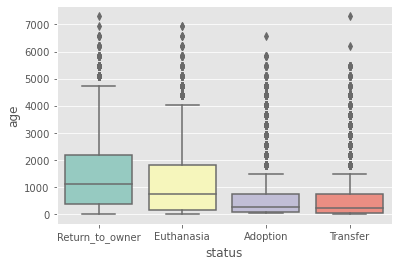

In [177]:
ax = sns.boxplot(y="age", x="status",
                 data=pd.DataFrame({'age':X.Age,'status':target.status}), palette="Set3")

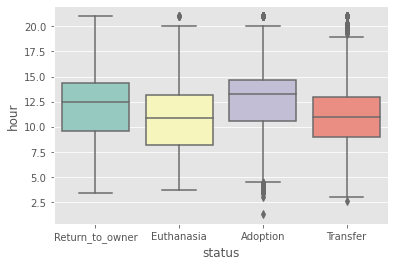

In [178]:
ax = sns.boxplot(y="hour", x="status",
                 data=pd.DataFrame({'hour':X.Hour,'status':target.status}), palette="Set3")

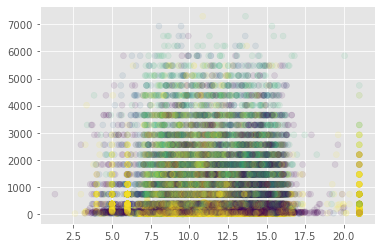

In [179]:
plt.scatter(x = X.Hour, y = X.Age,  c=y, alpha=0.1)
plt.show()

Неплохой результат. Попробуем улучшить его с помощью нейросеток. 

## 2. Собираем свою нейросеть

In [180]:
INPUT_SIZE = 37
HIDDEN_SIZE = 25
OUTPUT_SIZE = 4
LEARNING_RATE = 1e-3
EPOCHS = 100
BATCH_SIZE = 128

# Vanilla PyTorch

Код представленный выше от fastai значительно упрощает работу с нейронными сетями, но не дает понять, что же происходит на самом деле. Поэтому на первых порах лучше все писать самим. Для этого обратимся к первоисточнику, а именно к оригинальному PyTorch, с которого все началось. И для начала разберем все этапы работы с нейронной сети в упрощенной форме. 

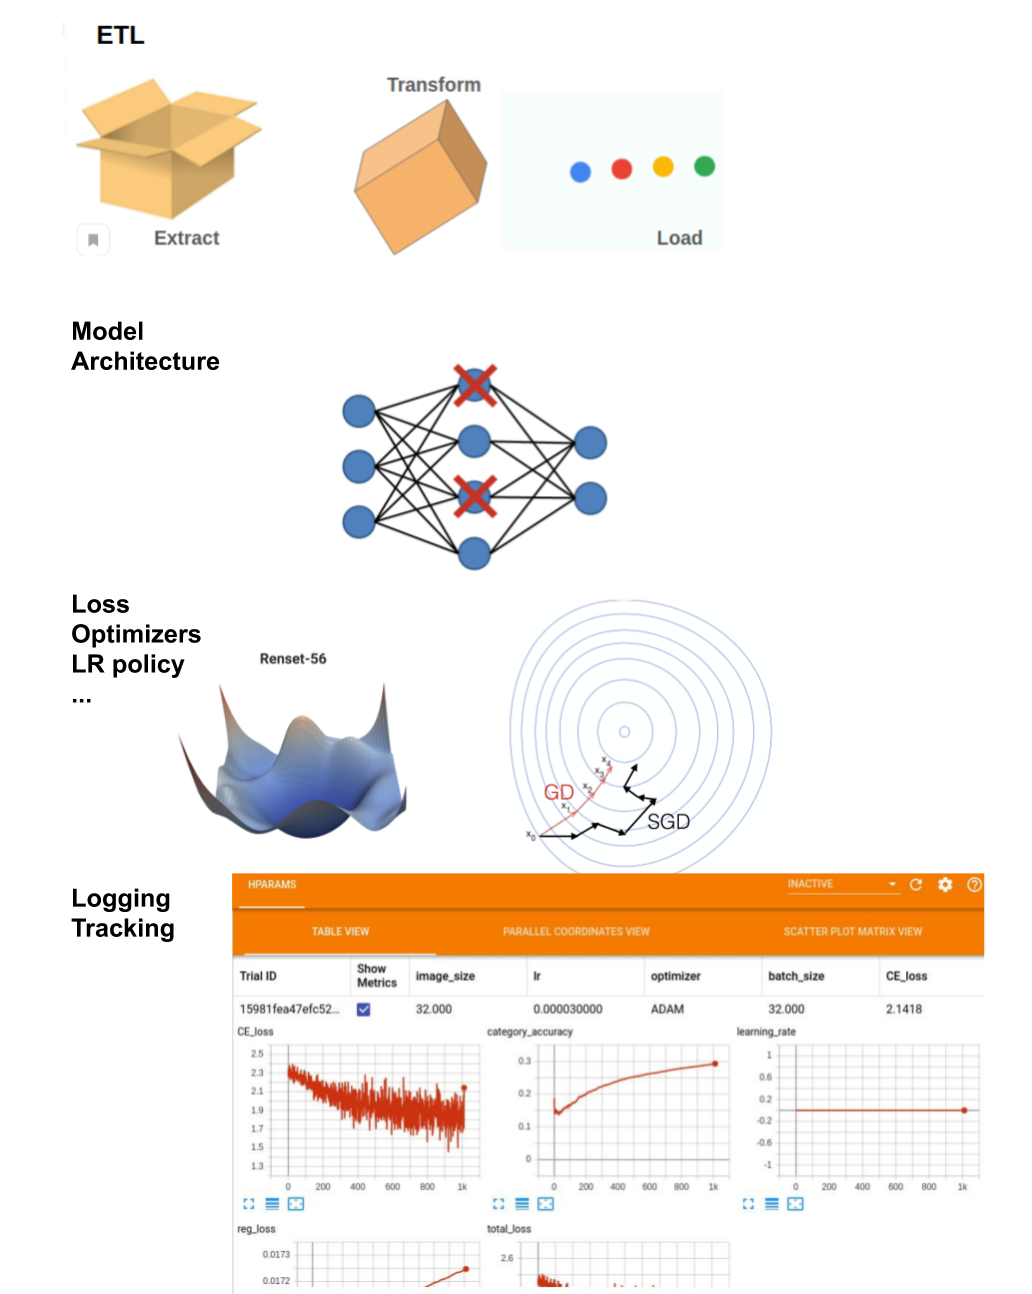

In [181]:
display.Image('images/Pipeline.png')

!pip install pytorch_lightning

In [182]:
import torch.nn as nn # содержит функции для реалзации архитектуры нейронных сетей
import torch.nn.functional as F # содержит различные функции активации и не только
import torch.optim as optim
import torch.utils.data as data_utils

from pytorch_lightning.metrics import Accuracy


Для того чтобы подавать данные в нейронную сеть, создадим `DataLoader`, который предоставляет гибкий API для работы с входными данными.

In [183]:
X_train, X_test, y_train, y_test = train_test_split(X.iloc[:, :].values, y,
                                                    test_size=0.2, stratify=y, random_state=42)

In [184]:
pd.Series(y).value_counts()

0    10769
3     9422
2     4786
1     1752
dtype: int64

Создание __DataLoader__ для обучения сети

In [185]:
torch.LongTensor

torch.LongTensor

In [186]:
def create_data_loader(X_train, y_train, X_test, y_test):
    train_tensor = data_utils.TensorDataset(torch.tensor(X_train.astype(np.float32)), torch.LongTensor(y_train))
#     train_tensor = data_utils.TensorDataset(torch.tensor(X_train.astype(np.float32)), torch.tensor(y_train))

    train_loader = data_utils.DataLoader(dataset=train_tensor,
                                         batch_size=BATCH_SIZE,
                                         shuffle=True)

    test_tensor = data_utils.TensorDataset(torch.tensor(X_test.astype(np.float32)), torch.LongTensor(y_test))
#     test_tensor = data_utils.TensorDataset(torch.tensor(X_test.astype(np.float32)), torch.tensor(y_test))

    test_loader = data_utils.DataLoader(dataset=test_tensor,
                                        batch_size=BATCH_SIZE,
                                        shuffle=False)
    return train_loader, test_loader

In [187]:
train_loader, test_loader = create_data_loader(X_train, y_train, X_test, y_test)

__Архитектура модели__

Архитектуру нейронной сети в PyTorch можно описать нескольками способами, в дальнейшем мы рассмотрим их более подробно. Сейчас предлагается сделать это используя `Sequential`.
`Sequential` -- это последовательный способ объявления каждой компоненты архитектуры нейронной сети.

In [188]:
def build_model():
    model = nn.Sequential(  
        # Добавляем в нашу модель первый слой из 25 нейронов
        nn.Linear(in_features=INPUT_SIZE, out_features=HIDDEN_SIZE),
        nn.Sigmoid(),
        
        # Добавляем ещё один слой из 25 нейронов
        nn.Linear(in_features=HIDDEN_SIZE, out_features=HIDDEN_SIZE),
        nn.Sigmoid(),
        
        # Выходной вектор на количество классов, получаем с помощью такого же линейного приеобразования,
        # как и предыдущие слои, но уже на нужное количество выходных нейронов (т.е. классов)
        nn.Linear(in_features=HIDDEN_SIZE, out_features=OUTPUT_SIZE),
        nn.Softmax()
    )

    return model

Функция `Linear` представляет собой полносвязный слой, где присутствуют обучаемая матрица и обучаемый баес.

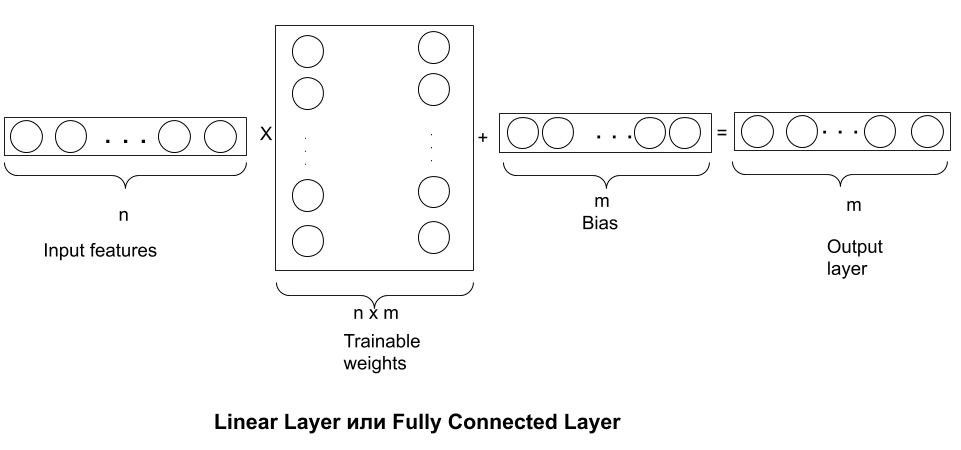

In [189]:
display.Image('images/FClayer.png')

In [190]:
model = build_model()

In [191]:
print(model)

Sequential(
  (0): Linear(in_features=37, out_features=25, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=25, out_features=25, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=25, out_features=4, bias=True)
  (5): Softmax(dim=None)
)


На лекции была представлена возможная архитектура сети для задачи классификации. Сейчас мы тоже собрали свою сеть с одним скрытым слоем.

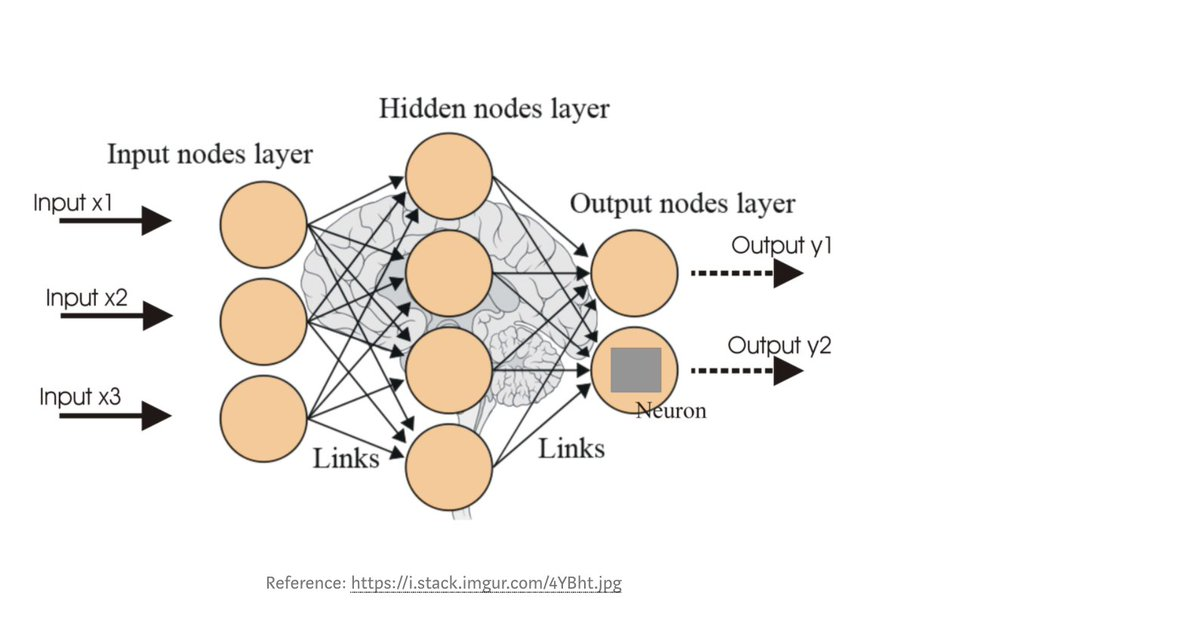

In [192]:
display.Image('images/MLP2.jpg')

Обратите внимание, что последняя функция в в архитектуре сети -- это `Softmax`. Напомним, что `Softamx` используется для задачи классификации, чтобы получить значение увернности сети по каждому классу. Получается вектор на заданное количество классов, где наибольшее значение в какой-либо координате говорит о том, что сеть считает данный класс наиболее подходящим для данного наблюдения.

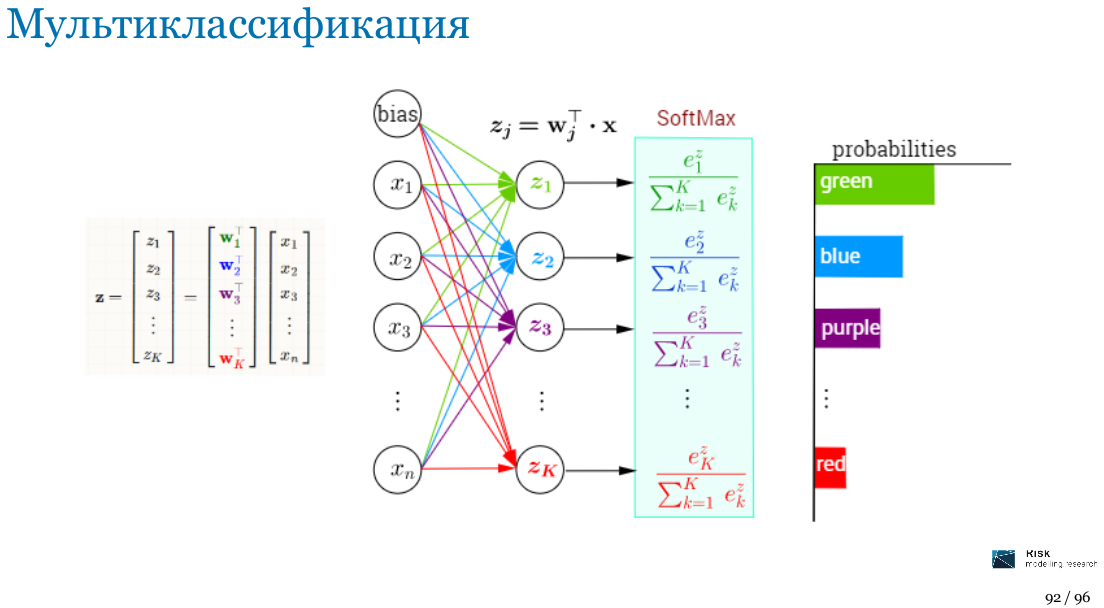

In [193]:
display.Image('images/Softmax.png')

Отлично! Только что мы собрали свою первую нейросеть со скрытым слоем. Осталось ее обучить.

__Обучение модели__

Перед тем как обучать нашу нейросеть, нужно задать параметры обучения. 
- Во-первых, метод оптимизации. 
- Во-вторых, функцию потерь. 
- В-третьих, парочку метрик, на которые нам хотелось бы смотреть в процессе обучения.  

In [194]:
criterion = nn.CrossEntropyLoss()
accuracy = Accuracy()

optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

Создадим массивы, куда будем складывать значение целевой функции на обучающей и валиационной выборках, а также точность.

Ниже представлен код __обучения__ сети. Нужно обратить внимание на несколько моментов:
1. Обучение ведется в течение нескольких эпох -- что значит несколько проходов по выборке.
2. `train_loader` позволяет итеративно проходится по выборке и на каждой итерации получать батч заранее заданного размера.
3. На каждом шаге обнуляем градиенты `optimizer.zero_grad()`, чтобы не накапливать их, тем самым неккоректно обновлять веса.
4. Вызывать явно `loss.backward()` для вычисления градиентов.
5. Вызывать явно `optimizer.step()` для обновления весов.

In [195]:
loss = nn.CrossEntropyLoss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)
output = loss(input, target)
output.backward()

In [196]:
step = 0
train_loss_values = []
train_accuracy_values = []
valid_loss_values = []
valid_accuracy = []

def run_train():
    step = 0
    for epoch in range(EPOCHS):
        running_loss = []
        running_acc = []
        for features, label in train_loader:
            # Reset gradients
            optimizer.zero_grad()

            output = model(features)
            # Calculate error and backpropagate
            loss = criterion(output, label)
            loss.backward()
            acc = accuracy(output, label).item()

            # Update weights with gradients
            optimizer.step()

            running_loss.append(loss.item())
            running_acc.append(acc)

            step += 1

        train_loss_values.append(np.mean(running_loss))
        train_accuracy_values.append(np.mean(running_acc))
        if epoch % 20 == 0:
            print('EPOCH %d : train_loss: %f' % (epoch, train_loss_values[-1]))#, train_accuracy_values[-1]))


        # Run validation
        running_loss = []
        running_acc = []
        for features, label in test_loader:
            output = model(features)
            # Calculate error and backpropagate
            loss = criterion(output, label)
            acc = accuracy(output, label).item()

            running_loss.append(loss.item())
            running_acc.append(acc)

        valid_loss_values.append(np.mean(running_loss))
        valid_accuracy.append(np.mean(running_acc))
        if epoch % 20 == 0:
            print('EPOCH %d : valid_loss: %f' % (epoch, valid_loss_values[-1]), (valid_accuracy[-1]))
        
    return train_loss_values, train_accuracy_values, valid_loss_values, valid_accuracy

In [197]:
train_loss_values, train_accuracy_values, valid_loss_values, valid_accuracy = run_train()

EPOCH 0 : train_loss: 1.371909
EPOCH 0 : valid_loss: 1.369163 0.35245459775129956
EPOCH 20 : train_loss: 1.315739
EPOCH 20 : valid_loss: 1.315415 0.40283345466568354
EPOCH 40 : train_loss: 1.302801
EPOCH 40 : valid_loss: 1.302656 0.40283345466568354
EPOCH 60 : train_loss: 1.297847
EPOCH 60 : valid_loss: 1.297608 0.40283345466568354
EPOCH 80 : train_loss: 1.295455
EPOCH 80 : valid_loss: 1.294840 0.40283345466568354


 Посмотрим на динамику ошибки и значение точности нашей модели во времени.

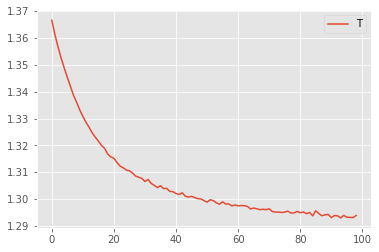

In [198]:
start = 1
plt.plot(train_loss_values[start:])
plt.legend('Train loss')

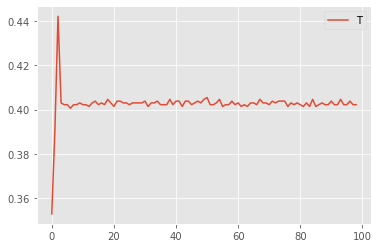

In [199]:
start = 1
plt.plot(train_accuracy_values[start:])
plt.legend('Train accuracy')

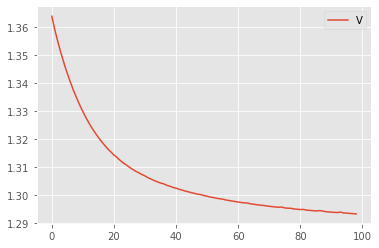

In [200]:
plt.plot(valid_loss_values[start:])
plt.legend('Validation loss')

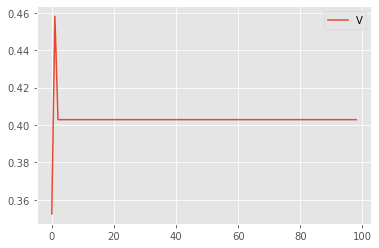

In [201]:
plt.plot(valid_accuracy[start:])
plt.legend('Validation accuracy')

Сохраним модель. Файл может иметь два расширения, как .pt, так и .pth. 

In [202]:
torch.save(model, 'simple_nn.pth')

Теперь загрузим сохраненную модель и посмотрим на ее предсказания. Важно! Когда идет этап inference модели, то нужно явно вызвать `model.eval()`, так как в случае если есть droupout или batch norm, то они не дложны работать как в процессе обучения, иначе они продолжат обучаться. 

In [203]:
model = torch.load('simple_nn.pth')
model.eval()

Sequential(
  (0): Linear(in_features=37, out_features=25, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=25, out_features=25, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=25, out_features=4, bias=True)
  (5): Softmax(dim=None)
)

In [204]:
# Выход модели (вероятность) на тестовой выборке
with torch.no_grad():
    test_scores = model(torch.tensor(X_test.astype(np.float32)))
print(accuracy(test_scores, torch.tensor(y_test.astype(np.int))).item())
print(test_scores.numpy())

0.4029180705547333
[[0.5630262  0.0188168  0.03468543 0.38347158]
 [0.56442726 0.01878804 0.03462977 0.38215497]
 [0.56358397 0.01880531 0.03466317 0.38294753]
 ...
 [0.564427   0.01878815 0.03462981 0.382155  ]
 [0.5632091  0.01881302 0.03467812 0.3832997 ]
 [0.5542032  0.01900492 0.03505456 0.39173728]]


In [205]:
# Предсказание классов на тестовой выборке
with torch.no_grad():
    test_scores = model(torch.tensor(X_test.astype(np.float32)))
predicted_classes = torch.argmax(test_scores, dim=1)
print(predicted_classes)

tensor([0, 0, 0,  ..., 0, 0, 0])


 Если `loss` еще падает, то точность не растет. __Как думаете, с чем это может быть связано?__

__Домашнее задание.__
Нужно обучить нейронную сеть, точность классификация должна быть не меньше __60%__. Как это можно получить:
1. Посмотрите на данные, характеристики.
2. Попробуйте менять гиперпараметры сети.
3. Обратите внимание на саму архитектуру сети.
4. Сделайте подсчет точности на валидационной выборке не через DataLoader.

в моей версии, нужно было заменить
```python
test_tensor = data_utils.TensorDataset(torch.tensor(X_test.astype(np.float32)), torch.LongTensor(y_test))
test_tensor = data_utils.TensorDataset(torch.tensor(X_test.astype(np.float32)), torch.tensor(y_test))
```

In [206]:
# Предсказание классов на тестовой выборке
with torch.no_grad():
    test_scores = model(torch.tensor(X_test.astype(np.float32)))
accuracy_score(test_scores.argmax(axis=1), y_test)

0.40291806958473625

# ответы про особенности данных
* по feature importance из деревьев - не очень важные некоторые
* факторы не масштабированные
## как можно переносить модель?
* model = model.to(device)

## про порядок действий:
1. traintest split
2. create_data_loader
3. build_model
4. setup:
    * criterion
    * accuracy
    * optimizer -try AdamW
5. run_train
6. plot
7. calculater losses


1. traintest split


In [207]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state = 42)


In [208]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
print(scaler.mean_)
X_test = scaler.transform(X_test)

[5.83828275e-01 7.89865413e+02 7.11453023e-01 5.99588458e+00
 8.29213886e-02 5.23499977e-01 3.57925025e-02 2.57380732e-01
 1.93658514e-01 8.34681757e-01 3.89140906e-01 4.27302062e-01
 2.97432540e-02 2.01442711e+03 6.93125380e+00 1.57265585e+01
 1.17897395e+01 6.57064023e-02 3.10994715e-02 3.29701164e-01
 2.18397793e-02 5.05541786e-02 7.10845064e-02 4.30014497e-01
 4.61113969e-01 4.97498012e-01 4.13880185e-02 6.95599308e-01
 2.63012674e-01 4.13880185e-02 1.38427723e-01 1.43665529e-01
 1.30477482e-01 1.25894402e-01 1.33610812e-01 1.65598840e-01
 1.62325212e-01]


In [209]:
INPUT_SIZE = 37
HIDDEN_SIZE = 25
OUTPUT_SIZE = 4
LEARNING_RATE = 1e-3
EPOCHS = 200
BATCH_SIZE = 256

2. create_data_loader
3. build_model


In [210]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cpu device


In [211]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(in_features=INPUT_SIZE, out_features=HIDDEN_SIZE),
            nn.ReLU(),
            nn.Linear(in_features=HIDDEN_SIZE, out_features=HIDDEN_SIZE),
            nn.ReLU(),
            nn.Linear(in_features=HIDDEN_SIZE, out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10, out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10, out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10, out_features=OUTPUT_SIZE),
            nn.Softmax()
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [212]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=37, out_features=25, bias=True)
    (1): ReLU()
    (2): Linear(in_features=25, out_features=25, bias=True)
    (3): ReLU()
    (4): Linear(in_features=25, out_features=10, bias=True)
    (5): ReLU()
    (6): Linear(in_features=10, out_features=10, bias=True)
    (7): ReLU()
    (8): Linear(in_features=10, out_features=10, bias=True)
    (9): ReLU()
    (10): Linear(in_features=10, out_features=4, bias=True)
    (11): Softmax(dim=None)
  )
)


3. build_model
4. setup:
    * criterion
    * accuracy
    * optimizer -try AdamW
5. run_train


In [213]:
train_loader, test_loader = create_data_loader(X_train, y_train, X_test, y_test)

In [214]:
criterion = nn.CrossEntropyLoss()
accuracy = Accuracy()

optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)


loss = nn.CrossEntropyLoss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)
output = loss(input, target)
output.backward()

step = 0
train_loss_values = []
train_accuracy_values = []
valid_loss_values = []
valid_accuracy = []

def run_train():
    step = 0
    for epoch in range(EPOCHS):
        running_loss = []
        running_acc = []
        for features, label in train_loader:
            # на каждом цикле относить в девайс каждый батч
            # Reset gradients
            optimizer.zero_grad()

            output = model(features)
            # на каждом цикле относить в девайс каждый фичи
            # Calculate error and backpropagate
            loss = criterion(output, label)
            loss.backward()
            acc = accuracy(output, label).item()

            # Update weights with gradients
            optimizer.step()

            running_loss.append(loss.item())
            running_acc.append(acc)

            step += 1

        train_loss_values.append(np.mean(running_loss))
        train_accuracy_values.append(np.mean(running_acc))
        if epoch % 20 == 0:
            print('EPOCH %d : train_loss: %f' % (epoch, train_loss_values[-1]))#, train_accuracy_values[-1]))


        # Run validation
        # тут переносить на gpu
        running_loss = []
        running_acc = []
        for features, label in test_loader:
            output = model(features)
            # Calculate error and backpropagate
            loss = criterion(output, label)
            acc = accuracy(output, label).item()

            running_loss.append(loss.item())
            running_acc.append(acc)

        valid_loss_values.append(np.mean(running_loss))
        valid_accuracy.append(np.mean(running_acc))
        if epoch % 20 == 0:
            print('EPOCH %d : valid_loss: %f' % (epoch, valid_loss_values[-1]), (valid_accuracy[-1]))
        
    return train_loss_values, train_accuracy_values, valid_loss_values, valid_accuracy

train_loss_values, train_accuracy_values, valid_loss_values, valid_accuracy = run_train()

EPOCH 0 : train_loss: 1.348672
EPOCH 0 : valid_loss: 1.274484 0.40308944384257
EPOCH 20 : train_loss: 1.074581
EPOCH 20 : valid_loss: 1.091452 0.6458168710981097
EPOCH 40 : train_loss: 1.064472
EPOCH 40 : valid_loss: 1.090312 0.6451847610019502
EPOCH 60 : train_loss: 1.057600
EPOCH 60 : valid_loss: 1.091128 0.647118954431443
EPOCH 80 : train_loss: 1.052706
EPOCH 80 : valid_loss: 1.094316 0.6439814454033261
EPOCH 100 : train_loss: 1.048319
EPOCH 100 : valid_loss: 1.096997 0.6426299782026381
EPOCH 120 : train_loss: 1.044785
EPOCH 120 : valid_loss: 1.096782 0.6446514158021837
EPOCH 140 : train_loss: 1.043563
EPOCH 140 : valid_loss: 1.097562 0.643002002012162
EPOCH 160 : train_loss: 1.042017
EPOCH 160 : valid_loss: 1.096997 0.6452835287366595
EPOCH 180 : train_loss: 1.042514
EPOCH 180 : valid_loss: 1.098915 0.6420719424883524


6. plot
7. calculater losses

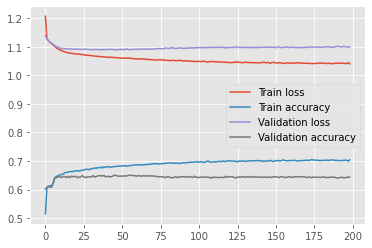

In [215]:
start = 1
plt.plot(train_loss_values[start:], label = 'Train loss')
plt.plot(train_accuracy_values[start:], label = 'Train accuracy')
plt.plot(valid_loss_values[start:], label = 'Validation loss')
plt.plot(valid_accuracy[start:],  label = 'Validation accuracy')
plt.legend()

In [216]:
# Предсказание классов на тестовой выборке
with torch.no_grad():
    test_scores = model(torch.tensor(X_test.astype(np.float32)))
accuracy_score(test_scores.argmax(axis=1), y_test)

0.6432846988402544

In [217]:
test_scores

tensor([[1.0000e+00, 5.4693e-42, 4.9897e-35, 3.8858e-29],
        [1.0000e+00, 2.1010e-24, 1.7323e-16, 1.0871e-19],
        [9.9997e-01, 5.2349e-35, 2.3810e-40, 2.6586e-05],
        ...,
        [1.0000e+00, 1.8612e-30, 5.6581e-21, 1.6765e-24],
        [2.7590e-02, 1.7685e-39, 4.0638e-44, 9.7241e-01],
        [1.0000e+00, 8.8012e-36, 1.1130e-23, 1.1626e-29]])